In [1]:
from six.moves import cPickle as pickle
import os
import shutil
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as disp # conflicting library function names
from IPython.display import Image as Im # conflicting library function names
from scipy import ndimage
import random

We have our raw image dataset. Now we can resize and reshape our images pickle it for convenience and prepare the dataset to be labeled.

In [2]:
def squareAndBWImage(image, size, path, species, name):
    # open our image
    im = Image.open(image)
    # dimmensions of square image
    size = (size,size)
    # resize our image and adjust if image is not square. save our image
    squared_image = ImageOps.fit(im, size, Image.ANTIALIAS)
    squared_image.save(path + '/' + species + '/squared_' + name)
    
def squareAndBWProcess(size, dataset_path, new_dataset_path):
    # if our dataset doesn't exist create it, otherwise overwrite
    if not os.path.exists(new_dataset_path):
        os.makedirs(new_dataset_path)
    else:
        shutil.rmtree(new_dataset_path)
        os.makedirs(new_dataset_path)
    
    # get a list of species folders in our dataset
    species_dataset = os.listdir(dataset_path)
    
    for species in species_dataset:
        os.makedirs(new_dataset_path + '/' + species)
        species_images = os.listdir(dataset_path + '/' + species)
        for image in species_images:
            image_path = dataset_path + '/' + species + '/' + image
            squareAndBWImage(image_path, size, new_dataset_path, species, image)

size = 100
dataset_path = '../dataset/spectrogram_roi_dataset'
new_dataset_path = '../dataset/squared_spectrogram_roi_dataset'
squareAndBWProcess(size, dataset_path, new_dataset_path)

Let's display a random sample from our dataset:

Here's a random sample from each class in the training dataset:
Basileuterus bivittatus sample :


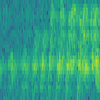

Basileuterus chrysogaster sample :


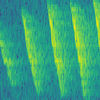

Chlorothraupis carmioli sample :


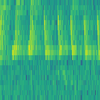

Eleutherodactylus brittoni sample :


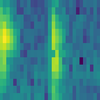

Eleutherodactylus cochranae sample :


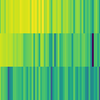

Eleutherodactylus cooki sample :


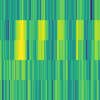

Eleutherodactylus coqui sample :


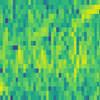

Eleutherodactylus juanariveroi sample :


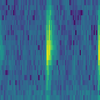

Epinephelus guttatus sample :


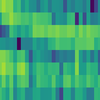

Formicarius analis sample :


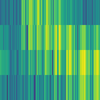

Hypocnemis subflava sample :


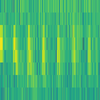

Liosceles thoracicus sample :


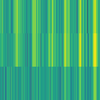

Megascops guatemalae sample :


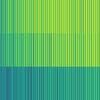

Megascops nudipes sample :


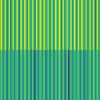

Microcerculus marginatus sample :


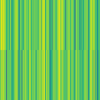

Myrmeciza hemimelaena sample :


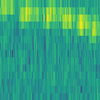

Myrmoborus leucophrys sample :


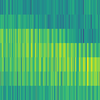

Percnostola lophotes sample :


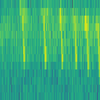

Saltator grossus sample :


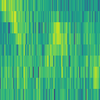

Thamnophilus schistaceus sample :


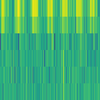

Unknown Insect sample :


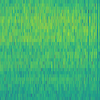

In [3]:
"""function for displaying a random photo from each class in a dataset"""
def displaySamples(dataset_folders):
    # go through each class in the dataset
    dataset = os.listdir(dataset_folders)
    for folder in dataset:
        imgs_path = dataset_folders + '/' + folder
        imgs = os.listdir(imgs_path) # list all images in a class
        sample = dataset_folders + '/' + folder + '/' + imgs[np.random.randint(len(imgs))] # path for a random image from a dataset class
        name = sample.split('/')[-2]
        print(name, 'sample :')
        disp(Im(sample)) # display our sample

print("Here's a random sample from each class in the training dataset:")
displaySamples(new_dataset_path)

In [4]:
def getDatasetFolders(dataset_path):
    folders = os.listdir(dataset_path)
    dataset_folders = []
    for folder in folders:
        dataset_folders.append(dataset_path + '/' + folder)
    return dataset_folders

dataset_folders = getDatasetFolders(new_dataset_path)

In [8]:
image_size = 100  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_image(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size, 4), dtype=np.float32)
    num_images = 0

    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            print(image_data.shape)
            # our images are RGBA so we would expect shape MxNx4
            # see: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.imread.html
            if (image_data.shape != (image_size, image_size,4)):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, pickles_path, force=False):
    
    if not os.path.exists(pickles_path):
        os.makedirs(pickles_path)
    else:
        shutil.rmtree(pickles_path)
        os.makedirs(pickles_path)
  
    dataset_names = []
    for folder in data_folders:
        class_name = folder.split('/')[-1] # species name
        set_filename = pickles_path + '/' + class_name + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_image(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names


#you can find the min number of images with a trivial function like this:
#min = 90000000
#dataset_folders = os.listdir('../dataset/squared_spectrogram_roi_dataset')
#for folder in dataset_folders:
#  images = os.listdir(dataset + '/' + folder)
#  count = 0
#  for image in images:
#    count += 1
#    if (count < min):
#      min = count

#print(min)

min_imgs_per_class = 5
pickles_path = '../dataset/pickle_data'
datasets = maybe_pickle(dataset_folders, min_imgs_per_class, pickles_path)

Pickling ../dataset/pickle_data/Basileuterus bivittatus.pickle.
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
Full dataset tensor: (15, 100, 100, 4)
Mean: 0.0817827
Standard deviation: 0.299721
Pickling ../dataset/pickle_data/Basileuterus chrysogaster.pickle.
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
Full dataset tensor: (5, 100, 100, 4)
Mean: 0.101836
Standard deviation: 0.294832
Pickling ../dataset/pickle_data/Chlorothraupis carmioli.pickle.
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
Full dataset tensor: (11, 100, 100, 4)
Mean: 0.0917893
Standard deviation: 0.298272
Pickling ../dataset/pickle_data/Eleutherodactylus brittoni.pickle.
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)
(100, 100, 4)

Let's check if our dataset is balanced:

In [16]:
# let's get our pickles
pickles = getDatasetFolders('../dataset/pickle_data')

In [17]:
print(datasets)

['../dataset/pickle_data/Basileuterus bivittatus.pickle', '../dataset/pickle_data/Basileuterus chrysogaster.pickle', '../dataset/pickle_data/Chlorothraupis carmioli.pickle', '../dataset/pickle_data/Eleutherodactylus brittoni.pickle', '../dataset/pickle_data/Eleutherodactylus cochranae.pickle', '../dataset/pickle_data/Eleutherodactylus cooki.pickle', '../dataset/pickle_data/Eleutherodactylus coqui.pickle', '../dataset/pickle_data/Eleutherodactylus juanariveroi.pickle', '../dataset/pickle_data/Epinephelus guttatus.pickle', '../dataset/pickle_data/Formicarius analis.pickle', '../dataset/pickle_data/Hypocnemis subflava.pickle', '../dataset/pickle_data/Liosceles thoracicus.pickle', '../dataset/pickle_data/Megascops guatemalae.pickle', '../dataset/pickle_data/Megascops nudipes.pickle', '../dataset/pickle_data/Microcerculus marginatus.pickle', '../dataset/pickle_data/Myrmeciza hemimelaena.pickle', '../dataset/pickle_data/Myrmoborus leucophrys.pickle', '../dataset/pickle_data/Percnostola lopho

In [33]:
def class_is_balanced(pickles):
    total = 0
    for pckle in pickles:
        if (os.path.isfile(pckle)):
            pickle_class = pickle.load(open(pckle, "rb"))
        else:
            print("Error reading dataset %s. Exiting.", pickle_path)
            return -1
        class_name = pckle.split('/')[-1].split('.')[0]
        print("The total number of images in class %s is: %d" % (class_name, len(pickle_class)))
        total += len(pickle_class)
    print("For the dataset to be balanced, each class should have approximately %d images.\n" % (total / len(pickles)))
    return (total // len(pickles))
    
print("Let's see if the dataset is balanced:")
balance_num = class_is_balanced(pickles)

Let's see if the dataset is balanced:
The total number of images in class Basileuterus bivittatus is: 15
The total number of images in class Basileuterus chrysogaster is: 5
The total number of images in class Chlorothraupis carmioli is: 11
The total number of images in class Eleutherodactylus brittoni is: 14
The total number of images in class Eleutherodactylus cochranae is: 25
The total number of images in class Eleutherodactylus cooki is: 16
The total number of images in class Eleutherodactylus coqui is: 13
The total number of images in class Eleutherodactylus juanariveroi is: 5
The total number of images in class Epinephelus guttatus is: 17
The total number of images in class Formicarius analis is: 11
The total number of images in class Hypocnemis subflava is: 24
The total number of images in class Liosceles thoracicus is: 14
The total number of images in class Megascops guatemalae is: 6
The total number of images in class Megascops nudipes is: 15
The total number of images in class

### Our dataset is not balanced :(

Now we'll merge, prune, and label our dataset. 

In [34]:
def getBalancedClasses(pickle_files, balanced_num):
    pickle_paths = []
    total = 0
    for pckle in pickle_files:
        if (os.path.isfile(pckle)):
            pickle_class = pickle.load(open(pckle, "rb"))
        else:
            print("Error reading dataset %s. Exiting.", pickle_path)
            return -1
        if (len(pickle_class) >= balance_num):
            total += len(pickle_class)
            pickle_paths.append(pckle)
    return pickle_paths, total

true_pickles, total_balanced = getBalancedClasses(pickles, balance_num)

print("balanced dataset is ", true_pickles)
print("Total images are ", total_balanced)
#balance_num = class_is_balanced(true_pickles)

#true_pickles = getBalancedClasses(pickles, balance_num)

#balance_num = class_is_balanced(true_pickles)

#true_pickles = getBalancedClasses(pickles, balance_num)

#balance_num = class_is_balanced(true_pickles)

balanced dataset is  ['../dataset/pickle_data/Basileuterus bivittatus.pickle', '../dataset/pickle_data/Eleutherodactylus cochranae.pickle', '../dataset/pickle_data/Eleutherodactylus cooki.pickle', '../dataset/pickle_data/Epinephelus guttatus.pickle', '../dataset/pickle_data/Hypocnemis subflava.pickle', '../dataset/pickle_data/Megascops nudipes.pickle', '../dataset/pickle_data/Myrmeciza hemimelaena.pickle', '../dataset/pickle_data/Myrmoborus leucophrys.pickle', '../dataset/pickle_data/Percnostola lophotes.pickle']
Total images are  197


In [49]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size,4), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets_all(pickle_files, train_size, valid_size, test_size): # valid_size is 0 if not given as argument. 
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    test_dataset, test_labels = make_arrays(test_size, image_size)

    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    tesize_per_class = test_size // num_classes
    
    start_v, start_t, start_te = 0, 0, 0
    end_v, end_t, end_te= vsize_per_class, tsize_per_class, tesize_per_class
    end_l = vsize_per_class + tsize_per_class
    end_tst = end_l + tesize_per_class
    

    for label, pickle_file in enumerate(pickle_files):
        #print(start_v, end_v)
        #print(start_t, end_v)
        name = (pickle_file.split('/')[-1]).split('.')[0]
        try:
            with open(pickle_file, 'rb') as f:
                species_set = pickle.load(f) # set of images from species
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(species_set) # shuffle the data (the "images") in the pickle around 
                

                print("Valid dataset with", name, ". Has ", len(species_set), " images.")
                print("Needs %d images per class" % vsize_per_class)
                print("valid_species is species_set[:%d,:,:]" % vsize_per_class)
                valid_species = species_set[:vsize_per_class, :, :,:]
                print("valid_dataset[%d:%d,:,:] = valid_species" % (start_v,end_v))
                valid_dataset[start_v:end_v, :, :,:] = valid_species
                print("valid_labels[%d:%d] = %d" % (start_v,end_v,label))
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class


                print("Train dataset with", name, ". Has ", len(species_set), " images")
                print("Needs %d images per class" % tsize_per_class)
                print("train_species is species_set[%d:%d,:,:]" % (vsize_per_class,end_l))
                train_species = species_set[vsize_per_class:end_l, :, :,:]
                print("train_dataset[%d:%d,:,:] = train_species" % (start_t,end_t))
                train_dataset[start_t:end_t, :, :,:] = train_species
                print("train_labels[%d:%d] = %d" % (start_t,end_t,label))
                train_labels[start_t:end_t] = label # give label to all images in class    
                start_t += tsize_per_class # offset start of class for next iteration 
                end_t += tsize_per_class # offset end of class for next iteration
                
                print("Test dataset with", name, ". Has ", len(species_set), " images")
                print("Needs %d images per class" % tesize_per_class)
                print("test_species is species_set[%d:%d,:,:]" % (end_l, end_te))
                test_species = species_set[end_l:end_tst, :, :, :]
                print("test_dataset[%d:%d,:,:] = test_species" % (start_te,end_te))
                test_dataset[start_te:end_te, :, :,:] = test_species
                print("test_labels[%d:%d] = %d" % (start_te,end_te,label))
                test_labels[start_te:end_te] = label # give label to all images in class
                start_te += tesize_per_class # offset start of class for next iteration 
                end_te += tesize_per_class # offset end of class for next iteration
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels
            
# the number of images in our training, validation, and testing dataset respectively
train_size = 70
valid_size = 35
test_size = 35

valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels = merge_datasets_all(true_pickles, train_size, valid_size, test_size)


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Valid dataset with Basileuterus bivittatus . Has  15  images.
Needs 3 images per class
valid_species is species_set[:3,:,:]
valid_dataset[0:3,:,:] = valid_species
valid_labels[0:3] = 0
Train dataset with Basileuterus bivittatus . Has  15  images
Needs 7 images per class
train_species is species_set[3:10,:,:]
train_dataset[0:7,:,:] = train_species
train_labels[0:7] = 0
Test dataset with Basileuterus bivittatus . Has  15  images
Needs 3 images per class
test_species is species_set[10:3,:,:]
test_dataset[0:3,:,:] = test_species
test_labels[0:3] = 0
Valid dataset with Eleutherodactylus cochranae . Has  25  images.
Needs 3 images per class
valid_species is species_set[:3,:,:]
valid_dataset[3:6,:,:] = valid_species
valid_labels[3:6] = 1
Train dataset with Eleutherodactylus cochranae . Has  25  images
Needs 7 images per class
train_species is species_set[3:10,:,:]
train_dataset[7:14,:,:] = train_species
train_labels[7:14] = 1
Test dataset with Eleutherodactylus cochranae . Has  25  images
Nee

In [50]:
# create dataset when dataset is not balanced, but want to use entire dataset
def merge_datasets_forced(pickle_files, train_size, valid_size=0): # valid_size is 0 if not given as argument. 
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)

    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class

    for label, pickle_file in enumerate(pickle_files):
        #print(start_v, end_v)
        #print(start_t, end_v)
        name = (pickle_file.split('/')[-1]).split('.')[0]
        try:
            with open(pickle_file, 'rb') as f:
                species_set = pickle.load(f) # set of images from species
                if(len(species_set) < (tsize_per_class + vsize_per_class)):
                    # since our dataset is not balanced we need to make sure
                    # we're not taking more images than we have or dimmensions will not match
                    # reset our ends to previous state, calculate new images_per_class, and 
                    # calculate new ends
                    
                    end_v -= vsize_per_class
                    end_t -= tsize_per_class 
                    
                    tsize_per_class = len(species_set) // 2
                    vsize_per_class = len(species_set) // 2
                    
                    end_v += vsize_per_class
                    end_t += tsize_per_class
                    end_l = vsize_per_class+tsize_per_class 
                    
                    
                    
                    # let's shuffle the letters to have random validation and training set
                    np.random.shuffle(species_set) # shuffle the data (the "images") in the pickle around 
                    if valid_dataset is not None: # if not testing dataset 

                        print("Valid dataset with", name, ". Has ", len(species_set), " images.")
                        print("Needs %d images per class" % vsize_per_class)
                        print("valid_species is species_set[:%d,:,:]" % vsize_per_class)
                        valid_species = species_set[:vsize_per_class, :, :,:]
                        print("valid_dataset[%d:%d,:,:] = valid_species" % (start_v,end_v))
                        valid_dataset[start_v:end_v, :, :,:] = valid_species
                        print("valid_labels[%d:%d] = %d" % (start_v,end_v,label))
                        valid_labels[start_v:end_v] = label
                        
                        # increment our start by how many images we used for this class
                        start_v += vsize_per_class
                        # assume next class will have the required images_per_class
                        end_v += (valid_size // num_classes)
                    
                        # can't reset vsize_per_class here since 
                        # the training dataset needs it's current state
                    
                    print("Train dataset with", name, ". Has ", len(species_set), " images")
                    print("Needs %d images per class" % tsize_per_class)
                    print("train_species is species_set[%d:%d,:,:]" % (vsize_per_class,end_l))
                    train_species = species_set[vsize_per_class:end_l, :, :,:]
                    print("train_dataset[%d:%d,:,:] = train_species" % (start_t,end_t))
                    train_dataset[start_t:end_t, :, :,:] = train_species
                    print("train_labels[%d:%d] = %d" % (start_t,end_t,label))
                    train_labels[start_t:end_t] = label # give label to all images in class
                    
                    # increment our start by how many images we used for this class
                    start_t += tsize_per_class 
                    # assume next round will have required images_per_class
                    tsize_per_class = train_size // num_classes
                    end_t += tsize_per_class # offset end of class for next iteration
                    vsize_per_class = valid_size // num_classes
                    end_l = vsize_per_class+tsize_per_class
                    
                    
                else: # we have enough images in this class to use our desired imgs_per_class
                    
                    
                    tsize_per_class = train_size // num_classes
                    vsize_per_class = valid_size // num_classes
                    end_l = vsize_per_class+tsize_per_class
                    
                
                    # let's shuffle the letters to have random validation and training set
                    np.random.shuffle(species_set) # shuffle the data (the "images") in the pickle around 
                    if valid_dataset is not None: # if not testing dataset 

                        print("Valid dataset with", name, ". Has ", len(species_set), " images.")
                        print("Needs %d images per class" % vsize_per_class)
                        print("valid_species is species_set[:%d,:,:]" % vsize_per_class)
                        valid_species = species_set[:vsize_per_class, :, :,:]
                        print("valid_dataset[%d:%d,:,:] = valid_species" % (start_v,end_v))
                        valid_dataset[start_v:end_v, :, :,:] = valid_species
                        print("valid_labels[%d:%d] = %d" % (start_v,end_v,label))
                        valid_labels[start_v:end_v] = label
                        start_v += vsize_per_class
                        end_v += vsize_per_class


                    print("Train dataset with", name, ". Has ", len(species_set), " images")
                    print("Needs %d images per class" % tsize_per_class)
                    print("train_species is species_set[%d:%d,:,:]" % (vsize_per_class,end_l))
                    train_species = species_set[vsize_per_class:end_l, :, :,:]
                    print("train_dataset[%d:%d,:,:] = train_species" % (start_t,end_t))
                    train_dataset[start_t:end_t, :, :,:] = train_species
                    print("train_labels[%d:%d] = %d" % (start_t,end_t,label))
                    train_labels[start_t:end_t] = label # give label to all images in class
                    
                    
                    
                    start_t += tsize_per_class # offset start of class for next iteration 
                    end_t += tsize_per_class # offset end of class for next iteration

        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
        print()
    
    return valid_dataset, valid_labels, train_dataset, train_labels



In [59]:
def genLabelMap(pickle_files):
    label_map = {}
    for label, pickle_file in enumerate(pickle_files):
        name = (pickle_file.split('/')[-1]).split('.')[0]
        label_map[label] = name
    return label_map

def sampleCheck(dataset, labels, label_map):
    i = random.randint(1, 5)
    for p_i, img in enumerate(random.sample(range(len(labels)), 5*i)):
        plt.subplot(i, 5, p_i+1)
        plt.axis('off')
        label = labels[img]
        species = label_map[label]
        #print(species)
        title =  species + ' sample:'
        plt.title(title)
        plt.imshow(dataset[img])
        plt.show()

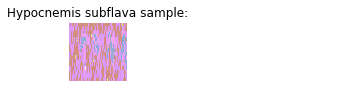

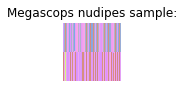

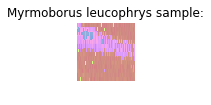

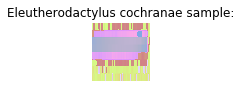

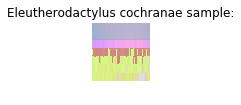

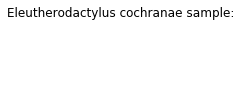

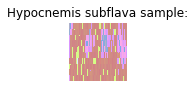

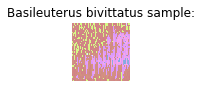

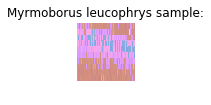

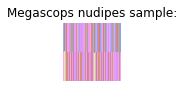

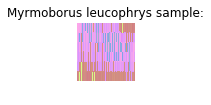

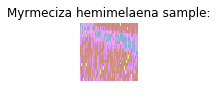

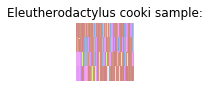

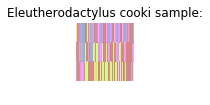

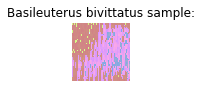

In [61]:
label_map = genLabelMap(true_pickles)
sampleCheck(train_dataset, train_labels,label_map)

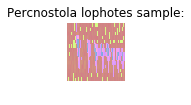

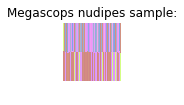

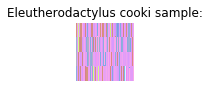

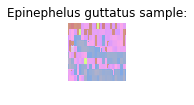

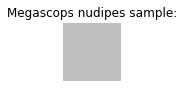

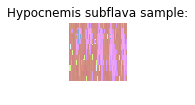

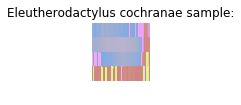

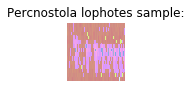

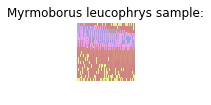

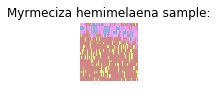

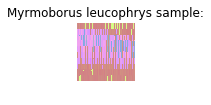

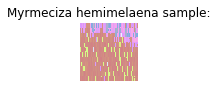

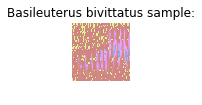

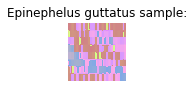

KeyError: 573341051

In [62]:
sampleCheck(valid_dataset, valid_labels, label_map)

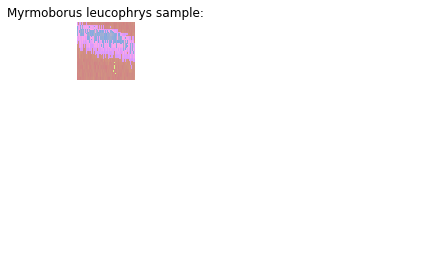

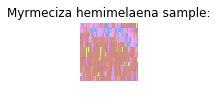

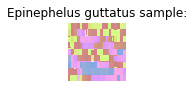

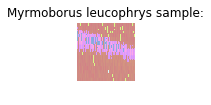

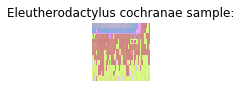

KeyError: 1072693248

In [63]:
sampleCheck(test_dataset, test_labels, label_map)

In [57]:
# serialize our dataset for later use

pickle_file = '../dataset/arbimonTest1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    } 
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL) # save all out datasets in one pickle 
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise